In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# This line is specific to Jupyter to make plots appear in the notebook
%matplotlib inline

# Load the reviews from the CSV file into a pandas DataFrame
df = pd.read_csv('_amazon fine food reviews.csv')

# Display the first 5 rows to get a quick look at the data
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,NaN,0.0,1.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,NaN,3.0,2.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQ4R3D8A9YL7,Melissa Myatt,1.0,1.0,5.0,1.351210e+09,Great taffy,Great taffy at a great price. There was a wide...


In [3]:
# a. Handle Missing Values
# Remove rows where the 'Text' or 'Score' columns are empty
df.dropna(subset=['Text', 'Score'], inplace=True)


# b. Create Sentiment Labels
# Remove neutral reviews (Score = 3)
df = df[df['Score'] != 3]
# Create a new 'Sentiment' column: 1 for positive (Score > 3), 0 for negative
df['Sentiment'] = np.where(df['Score'] > 3, 1, 0)


# c. Clean the Review Text
# Define a list of common English stopwords
stop_words = set([
    'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at',
    'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', "can't", 'cannot', 
    'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 
    'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", 
    "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", 
    "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', 
    "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 
    'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', 
    "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 
    'then', 'there', "there's", 'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 
    'to', 'too', 'under', 'until', 'up', 'very', 'was', "wasn't", 'we', "we'd", "we'll", "we're", "we've", 'were', 
    "weren't", 'what', "what's", 'when', "when's", 'where', "where's", 'which', 'while', 'who', "who's", 'whom', 'why', 
    "why's", 'with', "won't", 'would', "wouldn't", 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 
    'yourself', 'yourselves'
])

def clean_text(text):
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphabetic characters
    text = text.lower() # Convert to lowercase
    text = ' '.join(word for word in text.split() if word not in stop_words) # Remove stopwords
    return text

# Apply the cleaning function to the 'Text' column
df['CleanedText'] = df['Text'].apply(clean_text)

print("Data preprocessing complete.")
df[['Text', 'CleanedText', 'Score', 'Sentiment']].head()

Data preprocessing complete.


,Text,CleanedText,Score,Sentiment
0,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,5.0,1
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...,1.0,0
2,This is a confection that has been around a fe...,confection around centuries light pillowy citr...,4.0,1
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,2.0,0
4,Great taffy at a great price. There was a wide...,great taffy great price wide assortment yummy ...,5.0,1


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df['CleanedText'],
    df['Sentiment'],
    test_size=0.2,
    random_state=42,
    stratify=df['Sentiment']  # Ensures balanced classes in splits
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 23
Test set size: 6


In [5]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape of the training data (TF-IDF):", X_train_tfidf.shape)
print("Shape of the test data (TF-IDF):", X_test_tfidf.shape)

Shape of the training data (TF-IDF): (23, 161)
Shape of the test data (TF-IDF): (6, 161)


In [6]:
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train_tfidf, y_train)

print("Model training complete.")

Model training complete.


Confusion Matrix:


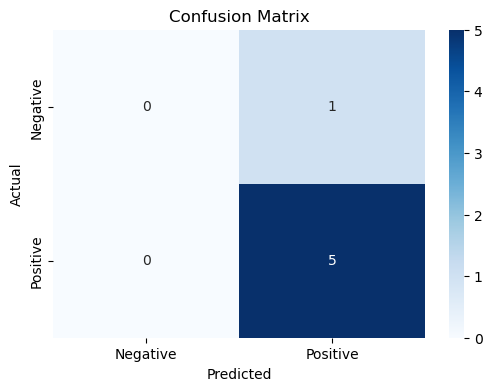

In [10]:
# Generate and display a confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))

# Corrected indentation below
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()